In [1]:
import openreview
from collections import Counter, defaultdict as dd
import numpy as np
import pandas as pd
import qgrid
from pprint import pprint
import datetime
import pickle
import re 
import time
import jellyfish
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def all_papers():
    client = openreview.Client(baseurl='https://openreview.net')
    paper_iterator = openreview.tools.iterget_notes(client, invitation='ICLR.cc/2019/Conference/-/Blind_Submission')
    return list(paper_iterator)

In [3]:
def ratings_and_confidence():
    client = openreview.Client(baseurl='https://openreview.net')
    review_iterator = openreview.tools.iterget_notes(client, invitation='ICLR.cc/2019/Conference/-/Paper.*/Official_Review')
    ratings = dd(list)
    confidence = dd(list)
    for review in review_iterator:
        ratings[review.forum].append(int(re.findall(pattern='\d+', string=review.content['rating'])[0]))
        confidence[review.forum].append(int(re.findall(pattern='\d+', string=review.content['confidence'])[0]))
    return ratings, confidence

In [4]:
papers = all_papers()
ratings, confidence = ratings_and_confidence()

In [5]:
def add_ratings(papers, ratings, confidence):
    for ix in range(len(papers)):
        forum = papers[ix].forum
        papers[ix].ratings = ratings.get(forum, [])
        papers[ix].confidence = confidence.get(forum, [])

In [6]:
add_ratings(papers, ratings, confidence)

In [9]:
def get_keywords(papers):
    return list(set([word.strip().lower() for p in papers for word in p.content['keywords']]))

def get_similarity(keywords):
    sim = dict()
    N = len(keywords)
    for i in range(N-1):
        for j in range(i+1, N):
            topic1 = keywords[i]
            topic2 = keywords[j]
            dist = len(set(topic1).intersection(set(topic2)))/len(set(max([topic1, topic2], key=lambda v: len(v))))
            if topic1 != topic2 and dist >= 0.70:
                dist = jellyfish.levenshtein_distance(topic1, topic2)
                sim[topic1, topic2] = dist
    return sim

def get_top_matches(sim):
    matches = dd(list)
    for pair in sim:
        if sim[pair] == 1:
            matches[pair[0]].append(pair[1])
            matches[pair[1]].append(pair[0])
    return matches    

In [10]:
keywords = get_keywords(papers)
start = time.time()
sim = get_similarity(keywords) # this may take several minutes 
finish = time.time()
print('Similarity computed in {:.2f} sec'.format(finish - start))

Similarity computed in 215.15 sec


In [11]:
matches = get_top_matches(sim)

In [12]:
def get_clusters(matches):
    clusters = dict()
    for topic in matches:
        values = matches[topic]
        clusters[topic] = topic
        for v in values:
            if len(matches.get(v, [])) > len(values) or \
            (len(matches.get(v, [])) == len(values) and topic > v):
                clusters[topic] = v
    return clusters

In [13]:
clusters = get_clusters(matches)

In [14]:
def get_df(papers, clusters):
    rows = []
    for paper in papers:
        topic = paper.content['keywords'][0] if len(paper.content['keywords']) else ''
        cluster = clusters.get(topic.lower(), topic.lower() if topic else None)
        row = dict(tldr = paper.content.get('TL;DR', ''),
                  ratings = getattr(paper, 'ratings', []),
                  confidence = getattr(paper, 'confidence', []),
                  title = paper.content['title'],
                  avg_rating = np.mean(getattr(paper, 'ratings', [])),
                  avg_confidence = np.mean(getattr(paper, 'confidence', [])),
                  topic = cluster,
                  url = "https://openreview.net/forum?id=" + paper.forum
                  )
        rows.append(row)
    df = pd.DataFrame(rows)
    df.index.name = 'Index'
    df = df.iloc[:, [4,1,0,6,5,3,2,7]]
    return df 

In [15]:
df = get_df(papers, clusters)

In [32]:
all_ratings = df['ratings'].agg(sum)
all_confidence = df['confidence'].agg(sum)
avg_rating = np.mean(all_ratings)
avg_confidence = np.mean(all_confidence)
import datetime
print('Statistics for', datetime.datetime.now().date())
print('Average rating: {:.1f}'.format(avg_rating))
print('Average confidence: {:.1f}'.format(avg_confidence))
print('Total number of reviews:', len(all_ratings))
print('Total number of papers:', df.shape[0])

Statistics for 2018-11-19
Average rating: 5.2
Average confidence: 3.8
Total number of reviews: 4576
Total number of papers: 1512


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


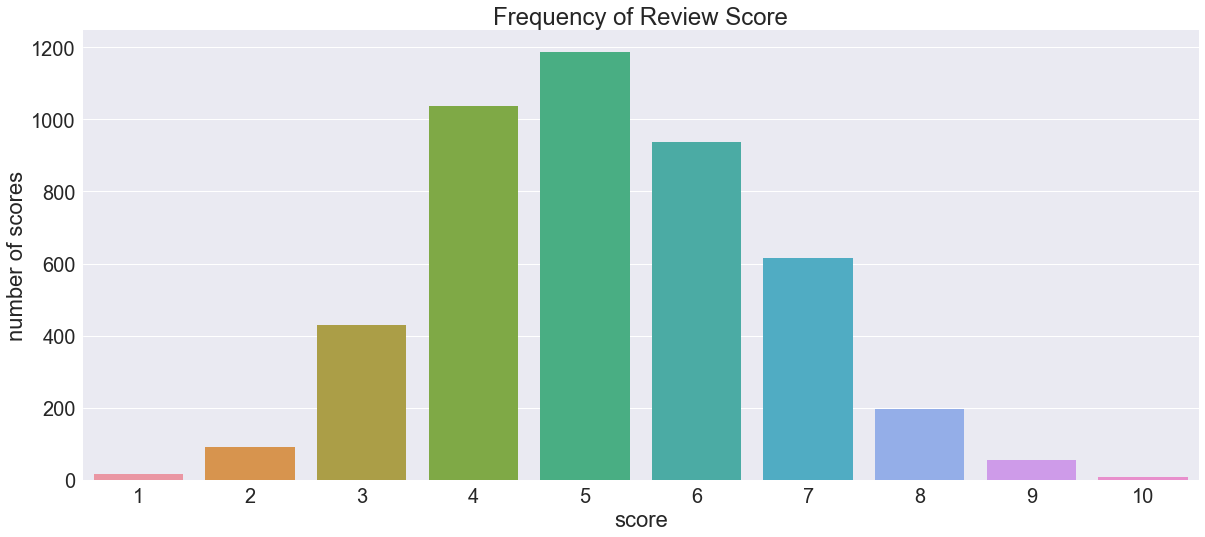

In [33]:
c = sorted(Counter(all_ratings).items())
freq = pd.DataFrame(c, columns = ['score', 'number'])
bars = sns.barplot(x='score', y='number', data=freq)
bars.set_title('Frequency of Review Score')
bars.set_ylabel('number of scores')
# xlabels = bars.set_xticklabels(bars.get_xticklabels(), rotation=90)
plt.show()

In [17]:
sns.set(rc={'figure.figsize':(20,8.27)}, font_scale=2)
def plot_heatmap(df):
    all_ratings = df['ratings'].agg(sum)
    all_confidence = df['confidence'].agg(sum)
    N, M = len(set(all_confidence)), len(set(all_ratings))
    heat = np.zeros((N, M))
    c = Counter(zip(all_confidence, all_ratings))
    for key in c:
        row, col = key
        heat[row-1, col-1] = c[key]
    normalized_heat = heat/np.linalg.norm(heat, axis=0)
    
    ax = sns.heatmap(normalized_heat, xticklabels=list(range(1,11)), yticklabels=list(range(1,6)), linewidths=.5)
    ax.set_title('Confidence in Reviews. \nNormalized for each review score.')
    ax.set_xlabel('Review Score')
    ax.set_ylabel('Confidence')
    plt.show()
    
def plot_frequencies(df):
    topics = Counter(df.topic).most_common(50)
    topics = list(filter(lambda v: v[0], topics))
    freq = pd.DataFrame(topics, columns = ['topic', 'occurences'])
    bars = sns.barplot(x='topic', y='occurences', data=freq)
    bars.set_title('Frequency of Popular Topics.')
    xlabels = bars.set_xticklabels(bars.get_xticklabels(), rotation=90)
    plt.show()

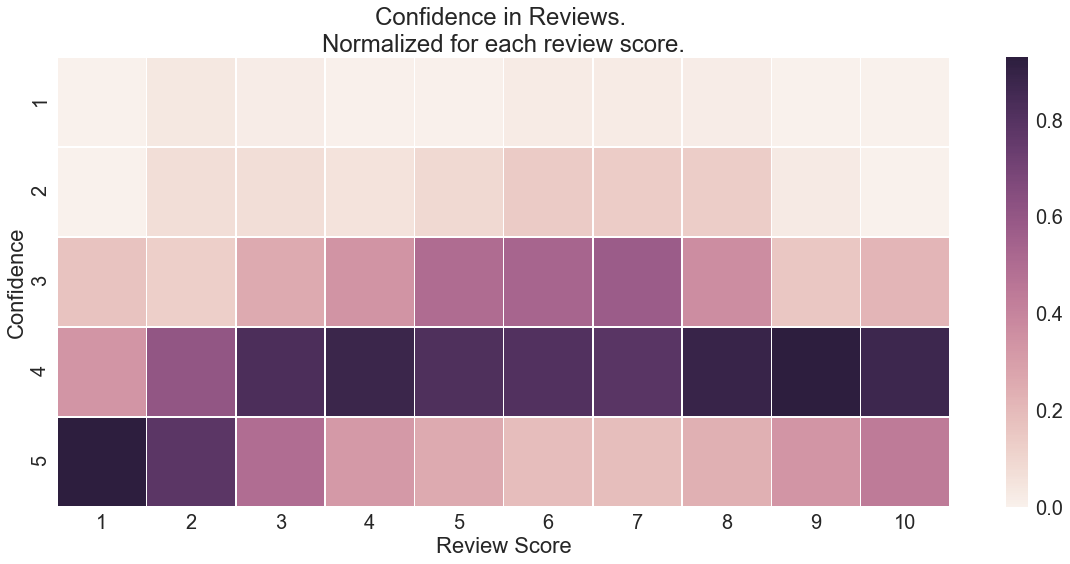

In [18]:
plot_heatmap(df)

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


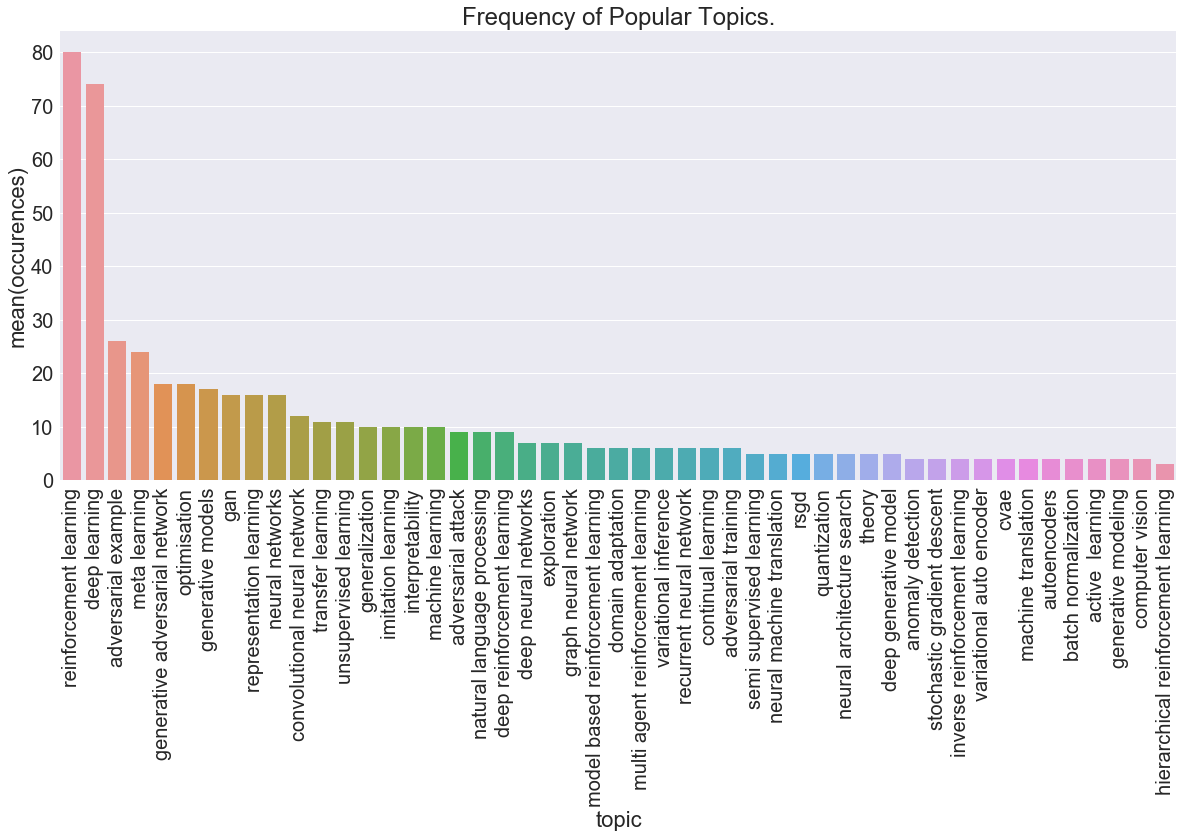

In [19]:
plot_frequencies(df)

In [40]:
col_defs = {
    name: {
        'width': 50
    } for name in ['Index', 'confidence', 'ratings']
}
col_defs['title'] = {'width': 500}
col_defs['avg_rating'] = {'width': 100}
col_defs['tldr'] = {'width': 1000}
col_defs['url'] = {'width': 300}
col_defs['topic'] = {'width': 200}
grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}
grid = qgrid.show_grid(df, column_definitions=col_defs, grid_options = grid_options, precision=1)

In [117]:
grid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [47]:
q = grid.get_changed_df()

In [48]:
q.shape

(748, 8)

In [193]:
abstracts = [paper.content['abstract'] for paper in papers]
titles = [paper.content['title'] for paper in papers]

In [254]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(abstracts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4, epochs = 10)

In [255]:
vecs = []
model.docvecs.most_similar(0)

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(1117, 0.9929732084274292),
 (1096, 0.9913002252578735),
 (40, 0.9902840852737427),
 (523, 0.9878532886505127),
 (296, 0.986305832862854),
 (433, 0.9819512367248535),
 (120, 0.9739929437637329),
 (1496, 0.9737836718559265),
 (415, 0.9711160659790039),
 (621, 0.9690467715263367)]

In [203]:
def recommend_papers(query, titles, abstracts, docvecs):
    ix = titles.index(query)
    matches = docvecs.most_similar(ix)
    recommendations = [(titles[m[0]], abstracts[m[0]], m[1]) for m in matches]
    sims = pd.DataFrame(recommendations, columns=['Title', 'Abstract', 'Similarity'])
    col_defs = {
        name: {
            'width': 50
        } for name in ['Index', 'confidence', 'ratings']
    }
    col_defs['Title'] = {'width': 500}
    col_defs['Abstract'] = {'width': 500}
    col_defs['Similarity'] = {'width': 100}
    grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100}
    grid = qgrid.show_grid(sims, column_definitions=col_defs, grid_options = grid_options, precision=3)
    return grid
    

In [259]:
df_dict.keys()

dict_keys(['title', 'avg_rating', 'avg_confidence', 'topic', 'tldr', 'ratings', 'confidence', 'url'])

In [260]:
title_d = dict()
for ix in range(df.shape[0]):
    title_d[df.iloc[ix, 0]] = {''}

# for ix, title in enumerate(titles):
#     row = df[df['title'] == title]
#     print(row.iloc[0, 1])
df_dict = df.to_dict()
df_dict['rev_title'] = {v: k for (k, v) in df_dict['title'].items()}
model.docvecs.most_similar(0)
rows = []
for title in df_dict['rev_title']:
    ix = df_dict['rev_title'][title]
    recs = model.docvecs.most_similar(ix)
    original_topic = df_dict['topic'][ix]
    for rec_paper in recs:
        j = rec_paper[0]
        rec_title = df_dict['title'][j]
        rec_avg_rating = df_dict['avg_rating'][j]
        rec_topic = df_dict['topic'][j]
        rec_tldr = df_dict['tldr'][j]
        rec_url = df_dict['url'][j]
        rows.append([title, original_topic, rec_title, rec_avg_rating, rec_topic, rec_tldr, rec_url])

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [269]:
df_rec = pd.DataFrame(rows, columns=['title', 'original_topic', 'rec_title', 'rec_avg_rating', 'rec_topic', 'rec_tldr', 'rec_url'])
df_rec = df_rec.set_index('title')

In [270]:
qgrid.show_grid(df_rec, column_definitions=col_defs, grid_options = grid_options, precision=3)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [ ]:
def get_fields(title, papers):
    for p in papers:
        if p.content['title'] == title:
            return p.content.get('tl;dr', ''), p.rating 

In [204]:
query = titles[0]
recommend_papers(query, titles, abstracts, model.docvecs)

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [233]:
df_rec = df.copy()

In [237]:
df_rec.head()

,title,avg_rating,avg_confidence,topic,tldr,ratings,confidence,url
Index,,,,,,,,
0,Adversarial Vulnerability of Neural Networks I...,5.750000,4.500000,adversarial vulnerability,Neural nets have large gradients by design; th...,"[5, 4, 9, 5]","[4, 5, 4, 5]",https://openreview.net/forum?id=H1MzKs05F7
1,Pixel Chem: A Representation for Predicting Ma...,2.333333,4.333333,material property prediction,"Proposed a unified, physics based representati...","[3, 1, 3]","[3, 5, 5]",https://openreview.net/forum?id=SkxYOiCqKX
2,On-Policy Trust Region Policy Optimisation wit...,5.000000,4.000000,reinforcement learning,We investigate the theoretical and practical e...,"[4, 6, 5]","[5, 3, 4]",https://openreview.net/forum?id=B1MB5oRqtQ
3,Deterministic Variational Inference for Robust...,6.666667,3.666667,bayesian neural network,A method for eliminating gradient variance and...,"[6, 7, 7]","[3, 3, 5]",https://openreview.net/forum?id=B1l08oAct7
4,What a difference a pixel makes: An empirical ...,4.666667,4.333333,deep learning,This study highlights a key difference between...,"[4, 3, 7]","[4, 4, 5]",https://openreview.net/forum?id=ByePUo05K7


In [219]:
def f(x):
    
    return recommend_papers(x, titles, abstracts, model.docvecs)

In [220]:
from ipywidgets import interact, Dropdown
widget  = interact(f, x=titles)

interactive(children=(Dropdown(description='x', options=('Adversarial Vulnerability of Neural Networks Increas…

In [114]:
part = pd.read_csv('part_prec.csv')

part['precision@0.9'].mean()
part.head()

,projections,count,precision@0.9
0,partnerId=12695,11395,0.120387
1,partnerId=17830,24258,0.048228
2,partnerId=21631,413,0.119048
3,partnerId=22597,2997,0.130000
4,partnerId=23082,5011,0.077465


In [77]:
part = pd.read_csv('part.csv')

part['AUC_100'].mean()

0.27094311506488555

In [115]:
# for puid 
camps = pd.read_csv('prospecting_campaigns', header=None, sep=';')
samples = []
for pin in camps[0]:
    try:
        q = part[part['projections'] == 'partnerId={}'.format(pin)]
        if q.shape[0] > 0:
            print(pin, float(q['precision@0.9']))
            samples.append(float(q['precision@0.9']))
    except:
        pass

16349 0.2133062468257999
34129 0.2694276407631456
20413 0.2585818090704084
21921 0.061488673139158574
22351 0.12897196261682242
25972 0.33544851456590713
13803 0.10772913816689468
42392 0.1250256200040992
18415 0.1044776119402985
35547 0.03674540682414698
37833 0.1353220925205361
18639 0.14786418400876233
2217 0.2485000967679505
38744 0.08333333333333333
32982 0.05681818181818181
39184 0.2144
3616 0.26502145922746784
15438 0.0934313725490196
21493 0.10462446703837323
13089 0.1243354991139988
37375 0.1518761983018351
11279 0.14394408335912515
2992 0.1951079959948505
9032 0.12401801111324008
7575 0.2781433440636243
5183 0.1076923076923077
7410 0.12658900314954655
31469 0.157450370724707
25953 0.09544111377368754
39404 0.060869565217391314
5814 0.22058823529411764
22707 0.1891891891891892
22709 0.0958302852962692
22708 0.11220196353436183
11953 0.12420281218698888
42556 0.11262798634812285
40320 0.20710059171597636
11251 0.17948917614078805
11788 0.05844155844155844
45264 0.11881606765327

In [116]:
pd.DataFrame(samples).mean()

0    0.141421
dtype: float64

In [70]:
import networkx as nx

G = nx.Graph()
G.add_edges_from([('A', 'B'), ('B', 'C')])


def random_walk_node_step(G, walks):
    new_walks = []
    for walk in walks:
        end = walk[-1]
        for v in G[end]:
            new_walks.append(walk + [v])
    return new_walks

def all_random_walks(G, node, steps):
    walks = []
#     for node in G:
#         walks.append([node])
    walks = [[node]]
    for _ in range(steps):
        new_walks = random_walk_node_step(G, walks)
        walks = new_walks
    return walks


def walk2pattern(walk):
    idx = 0
    pattern = []
    d = dict()
    for node in walk:
        if node not in d:
            d[node] = idx
            idx += 1
        pattern.append(d[node])
    return tuple(pattern)

def all_anonymous_walks(walks):
    return set([walk2pattern(walk) for walk in walks])
    
steps = 5
walksA = all_random_walks(G, 'A', steps)
walksB = all_random_walks(G, 'B', steps)
print(all_anonymous_walks(walksA))
print(all_anonymous_walks(walksB))

{(0, 1, 2, 1, 2, 1), (0, 1, 0, 1, 2, 1), (0, 1, 0, 1, 0, 1), (0, 1, 2, 1, 0, 1)}
{(0, 1, 0, 2, 0, 2), (0, 1, 0, 2, 0, 1), (0, 1, 0, 1, 0, 1), (0, 1, 0, 1, 0, 2)}


In [39]:
news = []
with open('../text.txt') as f:
    splits = f.read().split('|')
    for split in splits:
        print(split)
        if '2&' in split or '&2' in split:
            news.append(split)
'|'.join(news)

ResourceWithFile:511;additionalfeatures:101194;baba.initial_seed_on_prod_dataid:7129;baba.learning.spark.driver.memory:24g;baba.learning.spark.executor.heartbeatInterval:60s;baba.learning.spark.scheduler.maxRegisteredResourcesWaitingTime:1800s;baba.learning.spark.scheduler.minRegisteredResourcesRatio:0.2;baba.learning.spark_submit.executor-cores:12;baba.learning.spark_submit.executor-memory:16g;baba.learning.spark_submit.num-executors:40;baba.optimization.epochs:50;baba.optimization.hashbits:26;baba.optimization.lbfgs_stopping_criteria.relative_decrease:true;baba.optimization.sgd_epochs:0;baba.preprocessing.spark.executor.heartbeatInterval:60s;baba.preprocessing.spark_submit.executor-memory:16g;bits:26;continuousfeatures:101194;crossfeatures:1&100072&100139
1&100072&100140
1&100082&100108
1&100108
1&100121&100139
1&100121&100140
1&100128
1&100132
1&100133&31
1&100138
1&100145
1&100146
1&100156
1&100164
1&100165&31
1&100780
1&100783
1&100928
1&100929
1&100930
1&100931
1&100932
1&100933


'ResourceWithFile:511;additionalfeatures:101194;baba.initial_seed_on_prod_dataid:7129;baba.learning.spark.driver.memory:24g;baba.learning.spark.executor.heartbeatInterval:60s;baba.learning.spark.scheduler.maxRegisteredResourcesWaitingTime:1800s;baba.learning.spark.scheduler.minRegisteredResourcesRatio:0.2;baba.learning.spark_submit.executor-cores:12;baba.learning.spark_submit.executor-memory:16g;baba.learning.spark_submit.num-executors:40;baba.optimization.epochs:50;baba.optimization.hashbits:26;baba.optimization.lbfgs_stopping_criteria.relative_decrease:true;baba.optimization.sgd_epochs:0;baba.preprocessing.spark.executor.heartbeatInterval:60s;baba.preprocessing.spark_submit.executor-memory:16g;bits:26;continuousfeatures:101194;crossfeatures:1&100072&100139|1&100072&100140|1&100082&100108|1&2|1&23|1&295|100070&2|100070&23|100072&100132|100072&100145|100072&100164|100072&100738|100072&17|100072&23|100082&100734|100082&17&23|100082&17|100082&491|100121&23|100128&2|100132&100145|100132&1

In [229]:
from sklearn.metrics import roc_auc_score as roc, roc_curve

roc([1, 1, 0], [0.5, 0.5, 0.5])

0.5

In [224]:
?roc